In [79]:
import numpy as np, pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# Notes

EDA
- characterize nans
    - cols, rows
- check dtypes
    - numeric, categorical (nominal, ordinal, interval)
- check target for class balance
    - undersample can be better than oversample / imputing if we have enough data
- check target dep on continuous variables
    - make box plots and histograms
- explore balance of categorical variables
    - eg. if more men than women in dataset, should we expect an issue?

Model Prep / Feature Engineering
- no leakage
- nans
    - choose to fill or drop
    - could also drop rows with nan's rather than features (make sure this doesn't bias dataset)
    - if you drop nans, check balance of ind/dep variables doesn't change meaningfully
- categorical variables
    - trees - numerically encode (i.e. 1,2,3,4)
    - parametric - (n-1) one hot encoding for an n cardinality variable
    - reduce cardinality by binning (with kmeans for example)
- numeric variables
    - feature standardization - if parameterized AND regularized model is desired
        - maybe do this for categorical vars too (what does it hurt)
        - no need for trees (they use order)
        - ONLY USE TRAINING DATA to calculate transformation statistics
    - log transform - rescales those that typically follow power rule (price, income, etc)
- split - determine randomization unit / dimension for splitting (eg time)
    - might also want to recheck balances are preserved for both indep/dep vars


Model Train
- hypertune
- train different classes of models for comparison
    - eg linear, xgb, rf
- can create two models if we don't want to waste splitting on that
    - eg if its the weekend, behavior is way different... easy fix is to train two models

Model Evaluation
- precision requires a representative sample (think like kinetic's dset, who knows what's rep so precision could be subjective to which "negative" class examples we feed it
- recall/precision good for data imbalance depending on the business application (F1 score is the geometric mean of the two, could be helpful -- works because if either are 0 so is F1)
- AUC of the ROC curve 

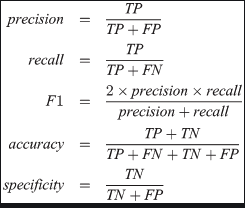

specificity is like recall but for the negative class (of all the negatives, how many did I label negative) - it's defined as (1 - False Positive Rate) - so its like the true negative rate and recall is the "true positive rate"

- ROC curve is made of TPR vs FPR

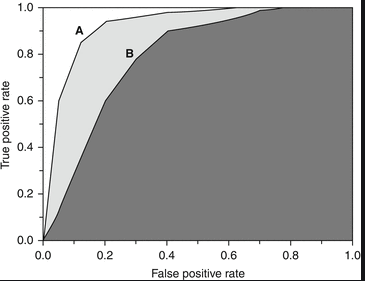

# Code

### Student performance Dataset
Lots of categorical independent variables with 3 numeric dependent variables
- can make a single numeric column by averaging the 3 scores (see that they are pretty correlated anyways so not a bad move)
- make a single categorical target by checking if they are "passing" (ie above 70% on their mean score)


https://www.kaggle.com/datasets/spscientist/students-performance-in-exams

In [59]:
df = pd.read_csv('StudentsPerformance.csv')
# create a single score to fit to (average their math, reading, writing)
df['mean_score'] = df[['math score', 'reading score','writing score']].mean(axis=1)
# create a discrete column to determine if they are passing students
df['passing'] = (df.mean_score > 70).astype(int)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean_score,passing
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,1
1,female,group C,some college,standard,completed,69,90,88,82.333333,1
2,female,group B,master's degree,standard,none,90,95,93,92.666667,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,0
4,male,group C,some college,standard,none,76,78,75,76.333333,1


### Nans

#### count nans

In [63]:
col = 'race/ethnicity'

# make a few of them nans
temp = df.copy()
temp.loc[[0,4], col] = np.nan

# check nans by column
temp.isna().sum()

gender                         0
race/ethnicity                 2
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
mean_score                     0
passing                        0
dtype: int64

#### drop cols or rows by nans

In [67]:
# drop a column
temp.drop(columns=[col]).head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean_score,passing
0,female,bachelor's degree,standard,none,72,72,74,72.666667,1
1,female,some college,standard,completed,69,90,88,82.333333,1
2,female,master's degree,standard,none,90,95,93,92.666667,1
3,male,associate's degree,free/reduced,none,47,57,44,49.333333,0
4,male,some college,standard,none,76,78,75,76.333333,1


Default behavior is to not reindex

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

In [69]:
col = 'race/ethnicity'

# make a few of them nans
temp = df.copy()
temp.loc[[0,4], col] = np.nan

# drop
temp.dropna().head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean_score,passing
1,female,group C,some college,standard,completed,69,90,88,82.333333,1
2,female,group B,master's degree,standard,none,90,95,93,92.666667,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,0
5,female,group B,associate's degree,standard,none,71,83,78,77.333333,1
6,female,group B,some college,standard,completed,88,95,92,91.666667,1


### Encoding categorical variables
- one hot - for parametric
- numerical encode - trees
    - ordinal we can fix the order of these with a dictionary (note still can't be used for parametric because spacing is not fixed)

#### One hot encode (nominal feature - parametric models)
- Technically if you one-hot encode all k labels of a categorical variable, you end up with an informationally redundant feature (eg you only need 2 vars to encode 3 labels since the last can be 00)
- For ML w/regularization - No need to drop one of the columns (removes issues with computational singularities)
    - Especially if the choice of column dropped may impact your prediction

`get dummies`
- we will use the race column and add a few nans
- we will track those nans with "dummy_na=True" flag
- we will add prefix of "race"
- we can choose to remove the redundant level by passing "drop_first" (removes multicollinearity - unnecssary if regularizing final model)
- finally we will concat these new cols by joining them to the original dset based on index

In [60]:
col = 'race/ethnicity'

# make a few of them nans
temp = df.copy()
temp.loc[[0,4], col] = np.nan

# # check nans
# display(temp.isna().sum())

# check encodings
display(temp[col].value_counts())

#########################################################
# ENCODE using get dummies (nans are preserved)
# returns a df with same number of rows and either n or n-1 cols (based on cardinality of feature)
encoded_cols = pd.get_dummies(temp[col], prefix='race', dummy_na=True, drop_first=True, dtype=int)
# concat new columns using pd.merge
temp = pd.merge(temp, encoded_cols, how='inner',right_index=True, left_index=True)
#########################################################

# display(encoded_cols.head())
display(temp.head())

race/ethnicity
group C    318
group D    262
group B    189
group E    140
group A     89
Name: count, dtype: int64

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean_score,passing,race_group B,race_group C,race_group D,race_group E,race_nan
0,female,NaN,bachelor's degree,standard,none,72,72,74,72.666667,1,0,0,0,0,1
1,female,group C,some college,standard,completed,69,90,88,82.333333,1,0,1,0,0,0
2,female,group B,master's degree,standard,none,90,95,93,92.666667,1,1,0,0,0,0
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,0,0,0,0,0,0
4,male,NaN,some college,standard,none,76,78,75,76.333333,1,0,0,0,0,1


#### Numeric encode (nominal feature - non parametric model)


2 ways to do this
- pandas category (neeed to track mappings yourself by adding a new column?)
    - nans are "-1"
- sklearn encoder (can overwrite the original column if you want)
    - nans stay nan
    - https://stackoverflow.com/a/58972877

In [61]:
col = 'race/ethnicity'
new_col = 'race_encoded'

# make a few of them nans
temp = df.copy()
temp.loc[[0,4], col] = np.nan

#
temp[new_col]=temp[col].astype('category').cat.codes
temp.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean_score,passing,race_encoded
0,female,NaN,bachelor's degree,standard,none,72,72,74,72.666667,1,-1
1,female,group C,some college,standard,completed,69,90,88,82.333333,1,2
2,female,group B,master's degree,standard,none,90,95,93,92.666667,1,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,0,0
4,male,NaN,some college,standard,none,76,78,75,76.333333,1,-1


In [57]:
from sklearn import preprocessing

# make a few of them nans
temp = df.copy()
temp.loc[[0,4]] = np.nan

# make a new encoder for each col (if you want to be able to inverse transform)
le1 = preprocessing.LabelEncoder()
temp['gender_encoded'] = le1.fit_transform(    temp['gender'])
temp['gender_decoded'] = le1.inverse_transform(temp['gender_encoded'])

# second column
le2 = preprocessing.LabelEncoder()
temp['race_encoded'] = le2.fit_transform(    temp['race/ethnicity'])
temp['race_decoded'] = le2.inverse_transform(temp['race_encoded'])

temp.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean_score,passing,race_encoded,gender_encoded,gender_decoded,race_decoded
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2,NaN,NaN
1,female,group C,some college,standard,completed,69.0,90.0,88.0,82.333333,1.0,2,0,female,group C
2,female,group B,master's degree,standard,none,90.0,95.0,93.0,92.666667,1.0,1,0,female,group B
3,male,group A,associate's degree,free/reduced,none,47.0,57.0,44.0,49.333333,0.0,0,1,male,group A
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2,NaN,NaN


#### ORDINAL (spacing not fixed)
- can encode with a dictionary to ensure order

In [26]:
# make a few of them nans
temp = df.copy()
temp.loc[[0,4],'parental level of education'] = np.nan

# # check nans
# display(temp.isna().sum())

# check encodings
display(temp['parental level of education'].value_counts())

# make a dict of encodings
parent_edu_codes = {
"some high school":0,
"high school":1,
"some college" :2,         
"associate's degree":3,
"bachelor's degree":4,
"master's degree":5}

#########################################################
# ENCODE using the dict
# nans are preserved
temp = temp.replace({'parental level of education':parent_edu_codes})
display(temp.head())
#########################################################

# see new encodings
display(temp['parental level of education'].value_counts())


parental level of education
some college          225
associate's degree    222
high school           196
some high school      179
bachelor's degree     117
master's degree        59
Name: count, dtype: int64

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,NaN,standard,none,72,72,74
1,female,group C,2.0,standard,completed,69,90,88
2,female,group B,5.0,standard,none,90,95,93
3,male,group A,3.0,free/reduced,none,47,57,44
4,male,group C,NaN,standard,none,76,78,75


parental level of education
2.0    225
3.0    222
1.0    196
0.0    179
4.0    117
5.0     59
Name: count, dtype: int64

### EDA

Make the data

In [110]:
# returns a single col of male bool
gender_cols = pd.get_dummies(df['gender'], drop_first=True, dtype=int)

temp = df.iloc[:,-5:].iloc[:,[0,1,2,4]] 
# concat new columns using pd.merge
temp = pd.merge( gender_cols, temp, how='inner',right_index=True, left_index=True)
temp.head()

,male,math score,reading score,writing score,passing
0,0,72,72,74,1
1,0,69,90,88,1
2,0,90,95,93,1
3,1,47,57,44,0
4,1,76,78,75,1


#### Check corr matrix

In [111]:
temp.corr()

,male,math score,reading score,writing score,passing
male,1.000000,0.167982,-0.244313,-0.301225,-0.126611
math score,0.167982,1.000000,0.817580,0.802642,0.719068
reading score,-0.244313,0.817580,1.000000,0.954598,0.777146
writing score,-0.301225,0.802642,0.954598,1.000000,0.762108
passing,-0.126611,0.719068,0.777146,0.762108,1.000000


#### Violing plots
Check dep on each ind var
- doesn't make sense for categorical vars

In [106]:
def plot_multiaxis_violinplot(df, feat_cols, class_col, x_axis_name='feats',y_axis_name='val', ax=None):
    ax = ax if ax!=None else plt.gca()
    # plt.figure(figsize=[8,4]) # the thinner boxes the easier to visualize trends
    df = df[feat_cols + [class_col]]
    melted_df  = pd.melt(df, class_col, var_name=x_axis_name, value_name=y_axis_name)
    sns.violinplot(x=x_axis_name, hue=class_col, y=y_axis_name, data=melted_df, ax=ax)
    ax.legend(loc=1, title=class_col)

    return ax

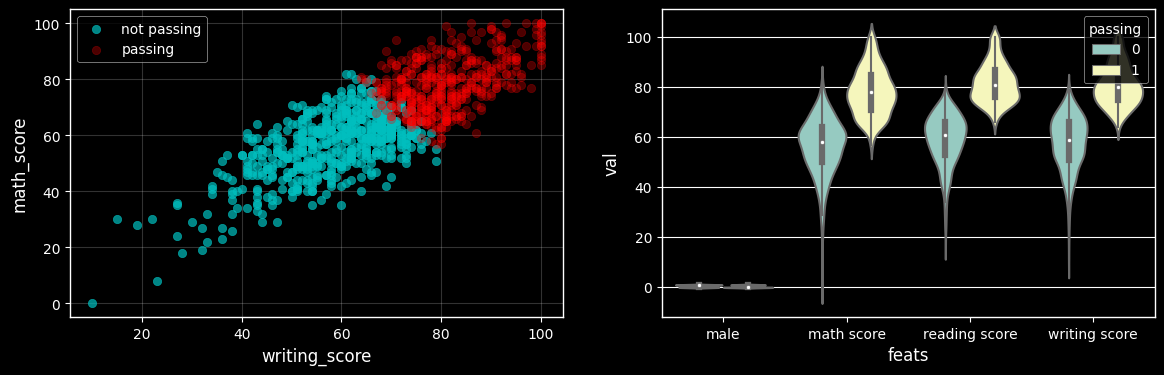

In [107]:
fig, axes = plt.subplots(1,2,figsize=(14,4))

ax=axes[0]
ax.scatter(data = temp.loc[temp.passing!=1], y='math score', x='writing score', c='c', alpha=0.7, label='not pass');
ax.scatter(data = temp.loc[temp.passing==1], y='math score', x='writing score', c='r', alpha=0.3, label='pass');
ax.grid(alpha=0.2)
ax.set_ylabel('math_score'); ax.set_xlabel('writing_score'); ax.legend(['not passing','passing']);

ax=axes[1]
feat_cols = ['male', 'math score', 'reading score', 'writing score']
ax = plot_multiaxis_violinplot(temp, feat_cols, 'passing', ax=ax)

See that it does weird stuff for binary columns (the value for male is [0,1] and yet it basically shows weight above and below those values )

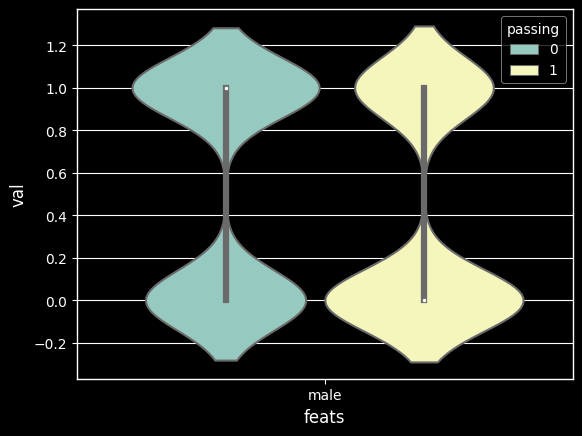

In [108]:
feat_cols = ['male']
ax = plot_multiaxis_violinplot(temp, feat_cols, 'passing')

### Training models

#### Splitting
Can either do it randomly or based on a column

In [112]:
# returns a single col of male bool
gender_cols = pd.get_dummies(df['gender'], drop_first=True, dtype=int)

temp = df.iloc[:,-5:].iloc[:,[0,1,2,4]] 
# concat new columns using pd.merge
temp = pd.merge( gender_cols, temp, how='inner',right_index=True, left_index=True)
temp.head()

,male,math score,reading score,writing score,passing
0,0,72,72,74,1
1,0,69,90,88,1
2,0,90,95,93,1
3,1,47,57,44,0
4,1,76,78,75,1


Random 80:10:10 (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html_)

In [121]:
from sklearn.model_selection import train_test_split

feat_cols = ['male', 'math score', 'reading score', 'writing score']
class_col = 'passing'

X, y = temp[feat_cols], temp[class_col]

# split off the training set
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# split the test/valid sets
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)

# check shapes
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape 

((800, 4), (100, 4), (100, 4), (800,), (100,), (100,))

Split based on randomization unit (eg gender - obviously a bad idea)

In [122]:
feat_cols = ['male', 'math score', 'reading score', 'writing score']
class_col = 'passing'
# train/test split (hold out the folds of honor data)
X_train = temp.query('male != 1')[feat_cols].dropna()
X_valid = temp.query('male == 1')[feat_cols].dropna()
y_train = temp[class_col].loc[X_train.index]
y_valid = temp[class_col].loc[X_valid.index]

# check shapes
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((518, 4), (482, 4), (518,), (482,))

#### Random forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [126]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test,y_test)

0.98

#### Feature importances

Mean Decrease in Impurity MDI
- looks at which features got split on and how early (averaged over trees)
- drawbacks are that
    - its based on training data (can't be evaluated on hold out set)
    - biased towards high cardinality since there are more splits there
- https://scikit-learn.org/stable/modules/ensemble.html#random-forest-feature-importance

male             0.000000
math score       0.289264
reading score    0.408259
writing score    0.302477
dtype: float64

Text(0, 0.5, 'Mean decrease in impurity')

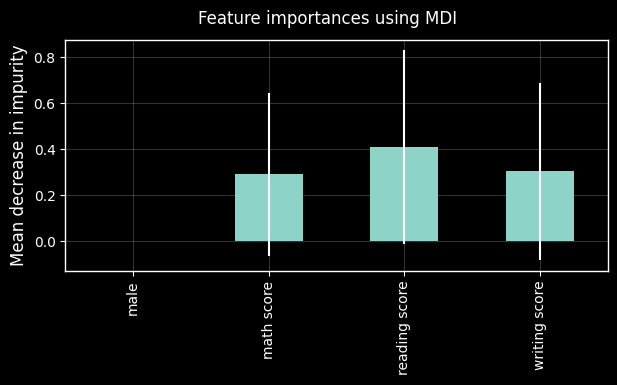

In [140]:

forest_importances = pd.Series(rf.feature_importances_, index=feat_cols)
display(forest_importances)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances.plot.bar(yerr=std, figsize=(7,3)); plt.grid(alpha=0.2)
plt.suptitle("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")

Permutation importance
- shuffles cols individually and evaluates new perf against the original
- can be used on test set if desired
- When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.
- https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm

male             0.000
math score       0.099
reading score    0.110
writing score    0.057
dtype: float64

Text(0, 0.5, 'Mean accuracy decrease')

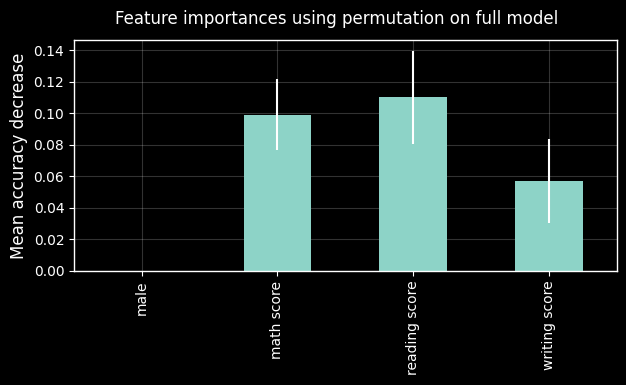

In [142]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feat_cols)
display(forest_importances)


forest_importances.plot.bar(yerr=result.importances_std, figsize=(7,3)); plt.grid(alpha=0.2)
plt.suptitle("Feature importances using permutation on full model")
plt.ylabel("Mean accuracy decrease")

#### ROC curve
- roc curve https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- auc https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score